##Esse é um notebook que constroe um jogo da velha que aprende a jogar com Deep Reinforcement Learning.

##Conexão com o Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Instalação das bibliotecas faltantes do google colab.

In [0]:
!pip install keras-rl2

     |████████████████████████████████| 51kB 2.3MB/s 
     |████████████████████████████████| 87.9MB 44kB/s 
     |████████████████████████████████| 3.1MB 48.5MB/s 
     |████████████████████████████████| 501kB 49.4MB/s 
  Created wheel for keras-rl2: filename=keras_rl2-1.0.3-cp36-none-any.whl size=52852 sha256=3c964446fa1ecc6d042716b89cf36171f407b759dc706c1778272602ff7e49d5
  Stored in directory: /root/.cache/pip/wheels/75/70/d7/65d0ca0a87c24f988435973065ef7ddf78af43a603a035aac0
Successfully built keras-rl2
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


###Importação das bibliotecas que serão usadas durante o código.

In [0]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy, LinearAnnealedPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import TrainIntervalLogger, FileLogger, ModelIntervalCheckpoint

###Criação da função que define o modelo de Redes Neurais Artificiais que será utilizado.

In [0]:
def cria_modelo(n_parametros, n_acoes, input_shape, janela_aprendizado, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=(janela_aprendizado,) + input_shape))

    rna.add(layers.Dense(1024,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    return rna

###Criação do embiente customizado para o agente, contruido seguindo os padrões dos ambientes do Gym (biblioteca de inteligência artificial criada pela OpenAI para reinforcement learning).

In [0]:
class JogoDaVelhaEnv(gym.Env):
    def __init__(self, teste=False):
        self.campo = None
        self.n_acoes = 9
        self.n_parametros = 9
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_acoes,), dtype=np.int8)
        self.teste = teste
        self.reset()

    def observacao(self):
        obs = np.empty(self.n_acoes, dtype=np.int8)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs

    def jogada_oponente(self):
        valido = False
        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def acabou(self, campo_ref=[]):

        if len(campo_ref) == 0:
            campo_ref = self.observacao()
        acabou = False
        resultado = 0
        
        for i in range(3):
            if campo_ref[0 + (i * 3)] + campo_ref[1 + (i * 3)] + campo_ref[2 + (i * 3)] in [3, -3]: #confere as linhas
                resultado = campo_ref[0 + (i * 3)] + campo_ref[1 + (i * 3)] + campo_ref[2 + (i * 3)]
            if campo_ref[0 + i] + campo_ref[3 + i] + campo_ref[6 + i] in [3, -3]: #confere as colunas
                resultado = campo_ref[0 + i] + campo_ref[3 + i] + campo_ref[6 + i]
            
        if campo_ref[0] + campo_ref[4] + campo_ref[8] in [3, -3]:
            resultado = campo_ref[0] + campo_ref[4] + campo_ref[8]
        if campo_ref[2] + campo_ref[4] + campo_ref[6] in [3, -3]:
            resultado = campo_ref[2] + campo_ref[4] + campo_ref[6]

        resultado = int(resultado / 3)
        if resultado != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return acabou, resultado

    def step(self, acao):

        recompensa_max = 0
        estado_antes = self.observacao()
        recompensa = 0
        valido = False
        acabou = True
        resultado = 0

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou, resultado = self.acabou()
            if acabou and resultado == 1:
                recompensa = 1
        else:
            recompensa = -1

        #confere se tem alguma jogada que podia ganhar
        if recompensa == 0:
            for jogada_ia in range(9):
                if estado_antes[jogada_ia] == 0:
                    estado_ref = []
                    for k in range(len(estado_antes)):
                        estado_ref.append(estado_antes[k])
                    estado_ref[jogada_ia] = 1
                    a, v = self.acabou(estado_ref)
                    if a and v == 1:
                        recompensa_max = 1
                        break
        elif recompensa == 1:
            recompensa_max = 1

        if valido and not acabou:
            self.jogada_oponente()
            acabou, resultado = self.acabou()
            if acabou and resultado == -1:
                recompensa = -1

        #caso nao podia ganhar, confere se tinha alguma jogada que previnia a vitoria do oponente
        if recompensa_max == 0 and recompensa == -1 and valido:
            qnt_vitorias = 0
            for jogada_op in range(9):
                if estado_antes[jogada_op] == 0:
                    estado_ref = []
                    for k in range(len(estado_antes)):
                        estado_ref.append(estado_antes[k])
                    estado_ref[jogada_op] = -1
                    a, v = self.acabou(estado_ref)
                    if a and v == -1:
                        qnt_vitorias += 1
            if qnt_vitorias >= 2:
                recompensa_max = -1

        return self.observacao(), recompensa, acabou, {'recompensa_max':recompensa_max}
        #return self.observacao(), recompensa, acabou, {}

    def reset(self):
        self.campo = np.zeros(self.n_parametros)
        comeca = bool(np.random.choice(2))
        if not self.teste and not comeca:
            self.jogada_oponente()
        return self.observacao()

    def render(self, mode='human'):
        estado = self.observacao()
        for i in range(len(estado)):
            if( i ) % 3 == 0:
                print()
            else:
                print('| ', end='')
            simbolo_maquina = 'O'
            simbolo_jogador = 'X'
            if estado[i] == -1:
                print(simbolo_jogador + ' ', end='')
            elif estado[i] == 1:
                print(simbolo_maquina + ' ', end='')
            else:
                print('- ', end='')
        print()

##Definição de todas as variáveis importantes do código.

In [0]:
np.random.seed(10)

ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
n_parametros = ambiente.n_parametros #define o numero de entradas da rede
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape

n_steps_1 = 50000
n_steps_2 = 100000
n_steps_aquecimento = int(n_steps_1 / 1000)
if n_steps_aquecimento < 100:
    n_steps_aquecimento = 100

janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)

modelo = cria_modelo( 9, 9, input_shape, janela_aprendizado, 0.3 )
metricas = ['accuracy']

n_steps_1_por_1000 = int(n_steps_1 / 1000)
n_steps_2_por_1000 = int(n_steps_2 / 1000)
agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_') #horario de brasilia UTC-3
caminho_export = '{0}{1}_{2}k_{3}k_steps_'.format( caminho_drive, agora, n_steps_1_por_1000, n_steps_2_por_1000 )

##Realização do treino com decaimento do epsilon.

In [0]:
eps_max = 1
eps_min = 0
#politica = MaxBoltzmannQPolicy( eps=0.5, tau=1.5 ) #tau grande -> Aleatorio, tau pequeno -> Greedy
#politica = EpsGreedyQPolicy( eps=epsilon / 100 )
politica = LinearAnnealedPolicy( inner_policy=EpsGreedyQPolicy(), attr='eps', value_max=eps_max, value_min=eps_min, nb_steps=n_steps_1, value_test=0 ) #0.2 antes do decay
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy(), nb_steps_warmup=n_steps_aquecimento )
agente.compile(optimizers.Adam(), metrics=metricas)

resultados_treino = []
intervalo_log_1 = int( n_steps_1 / 5 )
intervalo_modelo_1 = int( n_steps_1 / 5 )
callbacks_treino_1 = []
callbacks_treino_1.append( FileLogger( 'log_1.log' ) )
callbacks_treino_1.append( FileLogger( '{0}log_1.log'.format( caminho_export ) ) )
callbacks_treino_1.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_1.append( ModelIntervalCheckpoint( '{0}dqn_1.h5f'.format( caminho_export ) , interval=intervalo_modelo_1 ) )
historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=1, callbacks=callbacks_treino_1, log_interval=intervalo_log_1)
#historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=0, callbacks=callbacks_treino_1)

agente.save_weights('dqn_1.h5f', overwrite=True)
agente.save_weights( '{0}dqn_1.h5f'.format( caminho_export ), overwrite=True )

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -0.2674
3421 episodes - episode_reward: -0.782 [-1.000, 1.000] - loss: 0.165 - accuracy: 0.141 - mean_q: 0.440 - mean_eps: 0.899 - recompensa_max: 0.077

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: -0.1729
3310 episodes - episode_reward: -0.522 [-1.000, 1.000] - loss: 0.199 - accuracy: 0.219 - mean_q: 0.498 - mean_eps: 0.700 - recompensa_max: 0.116

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -0.0622
3210 episodes - episode_reward: -0.194 [-1.000, 1.000] - loss: 0.226 - accuracy: 0.305 - mean_q: 0.625 - mean_eps: 0.500 - recompensa_max: 0.160

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: 0.0548
3136 episodes - episode_reward: 0.175 [-1.000, 1.000] - loss: 0.216 - accuracy

##Realização do treino com epsilon = 0.

In [0]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_1.h5f')

intervalo_log_2 = int( n_steps_2 / 5 )
intervalo_modelo_2 = int( n_steps_2 / 5 )
callbacks_treino_2 = []
callbacks_treino_2.append( FileLogger( 'log_2.log' ) )
callbacks_treino_2.append( FileLogger( '{0}log_2.log'.format( caminho_export ) ) )
callbacks_treino_2.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_2.append( ModelIntervalCheckpoint( '{0}dqn_2.h5f'.format( caminho_export ) , interval=intervalo_modelo_2 ) )
historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_2, visualize=False, verbose=1, callbacks=callbacks_treino_2, log_interval=intervalo_log_2)
#historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_teste, visualize=False, verbose=0, callbacks=callbacks_treino_2)

agente.save_weights('dqn_2.h5f', overwrite=True)
agente.save_weights( '{0}dqn_2.h5f'.format( caminho_export ) , overwrite=True )

Training for 100000 steps ...
Interval 1 (0 steps performed)
20000/20000 [==============================] - 202s 10ms/step - reward: 0.2576
6114 episodes - episode_reward: 0.843 [-1.000, 1.000] - loss: 0.105 - accuracy: 0.770 - mean_q: 0.899 - recompensa_max: 0.280

Interval 2 (20000 steps performed)
20000/20000 [==============================] - 206s 10ms/step - reward: 0.2540
6106 episodes - episode_reward: 0.832 [-1.000, 1.000] - loss: 0.037 - accuracy: 0.931 - mean_q: 0.954 - recompensa_max: 0.280

Interval 3 (40000 steps performed)
20000/20000 [==============================] - 196s 10ms/step - reward: 0.2438
6117 episodes - episode_reward: 0.797 [-1.000, 1.000] - loss: 0.025 - accuracy: 0.960 - mean_q: 0.973 - recompensa_max: 0.274

Interval 4 (60000 steps performed)
20000/20000 [==============================] - 193s 10ms/step - reward: 0.2454
6120 episodes - episode_reward: 0.802 [-1.000, 1.000] - loss: 0.025 - accuracy: 0.963 - mean_q: 0.981 - recompensa_max: 0.272

Interval 5

##Visualização dos resultados do treino.

IndexError: ignored

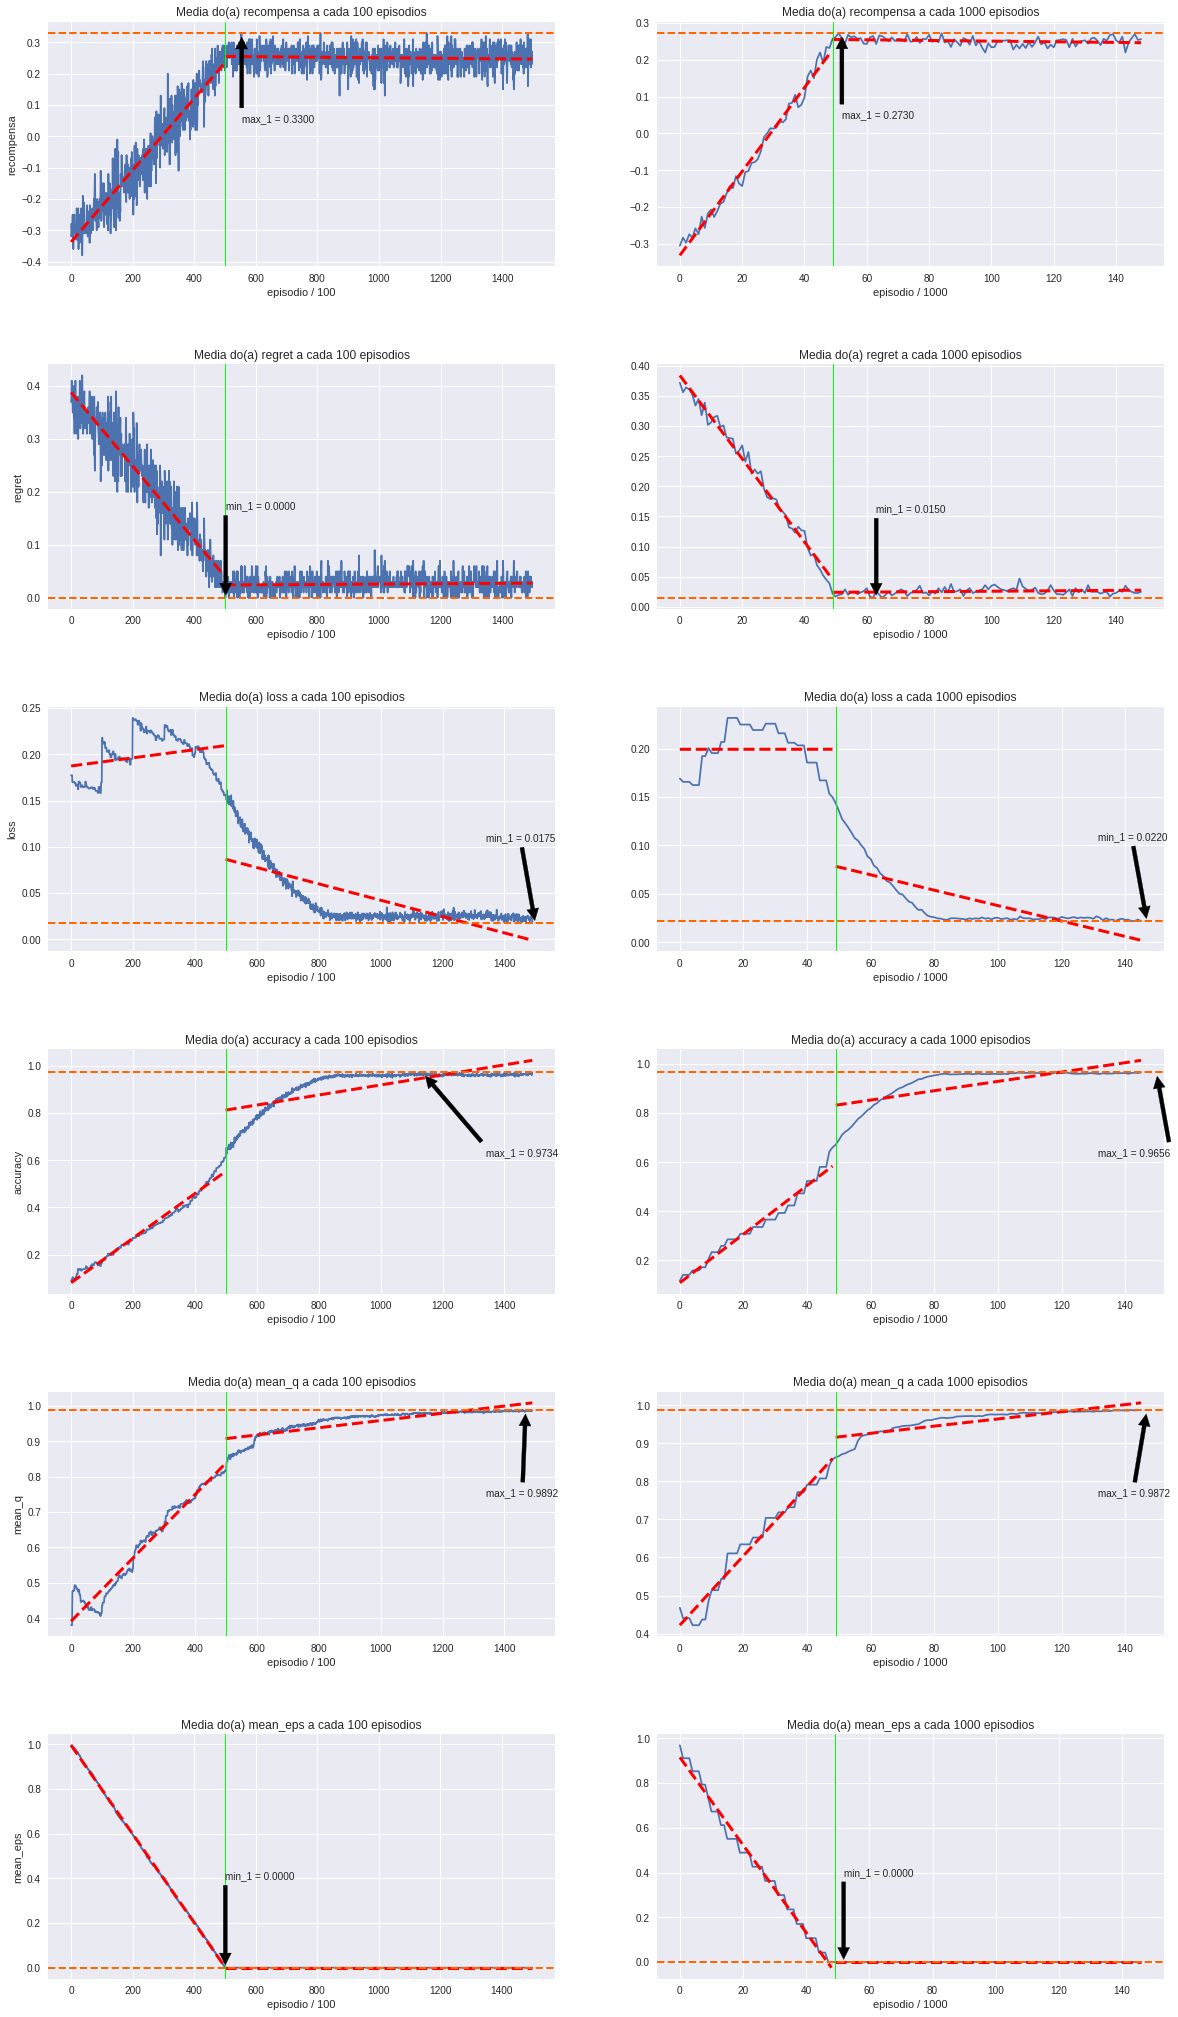

In [0]:
plt.style.use('seaborn')
nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
#nm_metricas = ['recompensa', 'regret', '']
metrica_max = [True, False, False, True, True, False]
divisores = [100, 1000]
#divisores = [1000]
result = resultados_treino
n_resultados = len(result)
tipo = 'treino_full'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
#fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = result[pular_n_steps]['episode']

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media_1 = [None, None]
        min_metrica_media_1 = [None, None]

        for i in range(0, n_resultados + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                #pega maximos e minimos
                if max_metrica_media_1[1] == None or metricas_media[-1] >= max_metrica_media_1[1]:
                    max_metrica_media_1[0] = i / divisor
                    max_metrica_media_1[1] = metricas_media[-1]
                if min_metrica_media_1[1] == None or metricas_media[-1] <= min_metrica_media_1[1]:
                    min_metrica_media_1[0] = i / divisor
                    min_metrica_media_1[1] = metricas_media[-1]
            if (i == n_resultados or result[i]['episode'] != ref) and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if i < n_resultados:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['recompensa_max'] - result[i]['reward'] )
                else: #outras metricas
                    if metrica_i - 2 == len(result[i]['metrics']): #se for o epsilon
                        metricas_ref.append( 0 )
                    else:
                        if not math.isnan( result[i]['metrics'][metrica_i-2] ): #tem que ser diferente de Not a Number (NaN)
                            metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        n_steps_media_treino_1 = int((n_steps_1 - pular_n_steps) / divisor)
        n_steps_media_total = len(metricas_media)
        #plota grafico
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[:n_steps_media_treino_1], metricas_media[:n_steps_media_treino_1], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[:n_steps_media_treino_1], p(x_plot[:n_steps_media_treino_1]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps decay')
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[n_steps_media_treino_1:], metricas_media[n_steps_media_treino_1:], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[n_steps_media_treino_1:], p(x_plot[n_steps_media_treino_1:]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps = 0')
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo_1
            anotacao_x_max = max_metrica_media_1[0]
            if max_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.6) + min_metrica_media_1[1]
            axes.axhline(max_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max_1 = {:.4f}'.format(max_metrica_media_1[1]), 
                                            xy=( max_metrica_media_1[0] , max_metrica_media_1[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo_1
            anotacao_x_min = min_metrica_media_1[0]
            if min_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.4) + min_metrica_media_1[1]
            axes.axhline(min_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min_1 = {:.4f}'.format(min_metrica_media_1[1]),
                                            xy=( min_metrica_media_1[0] , min_metrica_media_1[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        #linha do epsilon = 0
        axes.axvline( x=n_steps_media_treino_1, c='#00ff00' , linewidth=1, label='epsilon = 0')
        #if grafico == len(divisores) - 1:
        #    axes.legend()
        #axes.label_outer()
        #if metrica_i != len(nm_metricas) - 1:
        #    axes.axes.xaxis.set_visible(False)
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

##Visualização só do epsilon = 0.

In [0]:
plt.style.use('seaborn')
nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q']
metrica_max = [True, False, False, True, True, False]
divisores = [10, 100]
result = resultados_treino
n_resultados = len(result)
tipo = 'treino_eps0'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
#fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = result[n_steps_1]['episode']

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media_1 = [None, None]
        min_metrica_media_1 = [None, None]

        for i in range(n_steps_1, n_resultados + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                #pega maximos e minimos
                if max_metrica_media_1[1] == None or metricas_media[-1] >= max_metrica_media_1[1]:
                    max_metrica_media_1[0] = (i - n_steps_1) / divisor
                    max_metrica_media_1[1] = metricas_media[-1]
                if min_metrica_media_1[1] == None or metricas_media[-1] <= min_metrica_media_1[1]:
                    min_metrica_media_1[0] = (i - n_steps_1) / divisor
                    min_metrica_media_1[1] = metricas_media[-1]
            if (i == n_resultados or result[i]['episode'] != ref) and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if i < n_resultados:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['recompensa_max'] - result[i]['reward'] )
                else: #outras metricas
                    if not math.isnan( result[i]['metrics'][metrica_i-2] ): #tem que ser diferente de Not a Number (NaN)
                        metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        n_steps_media_total = len(metricas_media)
        #plota grafico
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot, metricas_media, 1)
        p = np.poly1d(z)
        axes.plot(x_plot, p(x_plot), c='#ff0000', ls="--", linewidth=3, label='tendencia')
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo_1
            anotacao_x_max = max_metrica_media_1[0]
            if max_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.6) + min_metrica_media_1[1]
            axes.axhline(max_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max_1 = {:.4f}'.format(max_metrica_media_1[1]), 
                                            xy=( max_metrica_media_1[0] , max_metrica_media_1[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo_1
            anotacao_x_min = min_metrica_media_1[0]
            if min_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.4) + min_metrica_media_1[1]
            axes.axhline(min_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min_1 = {:.4f}'.format(min_metrica_media_1[1]),
                                            xy=( min_metrica_media_1[0] , min_metrica_media_1[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

###Testando o agente.

In [0]:
print( "IA = 'O' e oponente = 'X'" )
retorno = agente.test(ambiente, nb_episodes=100, verbose=1, visualize=False)

agente.test(ambiente, nb_episodes=5, visualize=True)

###Jogando contra o agente treinado.

In [0]:
def jogada_agente(agente, estado):
    estado_reshape = [estado]
    saida = agente.compute_q_values( estado_reshape )
    jogada = np.argmax( saida )
    return jogada

#jogar contra a maquina
ambiente = JogoDaVelhaEnv( teste=True ) #cria o ambiente para o jogo
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam())
agente.load_weights('dqn.h5f')

vez_do_jogador = False
acabou = False
simbolo_jogador = 'X'

while not acabou:
    if vez_do_jogador:
        #jogada do jogador
        jogada_valida = False
        while not jogada_valida:
            jogada = int(input('campo a jogar: '))
            if ambiente.campo[ jogada ] != 0:
                print('campo inválido')
            else:
                ambiente.campo[ jogada ] = -1
                jogada_valida = True
                acabou, resultado = ambiente.acabou()

    else:
        #jogada da maquina
        jogada_valida = False
        jogada = jogada_agente( agente, ambiente.observacao() )
        if ambiente.campo[ jogada ] == 0:
            ambiente.campo[ jogada ] = 1
            acabou, resultado = ambiente.acabou()
        else:
            print('jogada invalida da IA')
            acabou = True
            resultado = -1
    
    vez_do_jogador = not vez_do_jogador
    ambiente.render()

ganhador = None #define uma variavel para quem ganhou o jogo
if resultado == -1: #se o resultado for 1
    ganhador = 'Voce ganhou' #o ganhador foi a IA
elif resultado == 1: #se o resultado for -1
    ganhador = 'A IA ganhou' #o ganhador foi o oponente aleatorio
else: #se o resultado for 0
    ganhador = 'Deu velha' #o jogo deu velha

print(ganhador)